In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

def load_data(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

# Preprocesar
def preprocess_data(train_df, test_df):
    X_train = train_df.drop(columns=['filename', 'class'])
    y_train = train_df['class']
    X_test = test_df.drop(columns=['filename', 'class'] if 'class' in test_df.columns else ['filename'])

    # Scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Encode
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)

    # Convert to PyTorch tensors 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.long).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

    return X_train, y_train, X_test, label_encoder


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size1),
            nn.Dropout(0.25)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size2),
            nn.Dropout(0.25)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size3),
            nn.Dropout(0.25)
        )
        self.output_layer = nn.Linear(hidden_size3, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output_layer(x)
        return x

In [ ]:
# Entrenar el modelo
def train_model(model, criterion, optimizer, X_train, y_train, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Hacer predicciones
def predict_model(model, X_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        _, predicted = torch.max(y_pred, 1)
    return predicted.cpu().numpy()


In [24]:
train_data = pd.read_csv('./data-vectors/train/train.csv')
train_labels = pd.read_csv('./train_labels.csv')
test_labels = pd.read_csv('./test_labels.csv')

train_filenames = train_labels['idx'].astype(str).apply(lambda x: x + '.wav')
test_filenames = test_labels['idx'].astype(str).apply(lambda x: x + '.wav')

train_df = train_data[train_data['filename'].isin(train_filenames)]
test_df = train_data[train_data['filename'].isin(test_filenames)]


In [25]:
X_train, y_train, X_test, label_encoder = preprocess_data(train_df, test_df)

In [26]:
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 64
hidden_size3 = 32
num_classes = len(label_encoder.classes_)
num_epochs = 5000
learning_rate = 0.001

model = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes).to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Entrenar 
train_model(model, criterion, optimizer, X_train, y_train, num_epochs)

predicted = predict_model(model, X_test)
predicted_labels = label_encoder.inverse_transform(predicted)
print(predicted_labels)

Epoch [10/5000], Loss: 0.5070
Epoch [20/5000], Loss: 0.4865
Epoch [30/5000], Loss: 0.4741
Epoch [40/5000], Loss: 0.4708
Epoch [50/5000], Loss: 0.4670
Epoch [60/5000], Loss: 0.4629
Epoch [70/5000], Loss: 0.4591
Epoch [80/5000], Loss: 0.4591
Epoch [90/5000], Loss: 0.4499
Epoch [100/5000], Loss: 0.4521
Epoch [110/5000], Loss: 0.4499
Epoch [120/5000], Loss: 0.4423
Epoch [130/5000], Loss: 0.4460
Epoch [140/5000], Loss: 0.4400
Epoch [150/5000], Loss: 0.4381
Epoch [160/5000], Loss: 0.4363
Epoch [170/5000], Loss: 0.4364
Epoch [180/5000], Loss: 0.4297
Epoch [190/5000], Loss: 0.4303
Epoch [200/5000], Loss: 0.4297
Epoch [210/5000], Loss: 0.4289
Epoch [220/5000], Loss: 0.4258
Epoch [230/5000], Loss: 0.4221
Epoch [240/5000], Loss: 0.4253
Epoch [250/5000], Loss: 0.4182
Epoch [260/5000], Loss: 0.4204
Epoch [270/5000], Loss: 0.4162
Epoch [280/5000], Loss: 0.4181
Epoch [290/5000], Loss: 0.4159
Epoch [300/5000], Loss: 0.4116
Epoch [310/5000], Loss: 0.4129
Epoch [320/5000], Loss: 0.4087
Epoch [330/5000],

In [27]:
y_test = test_df['class']

accuracy = (y_test== predicted_labels).mean() * 100
print(f"El accuracy es: {accuracy:.2f}%")

El accuracy es: 77.00%


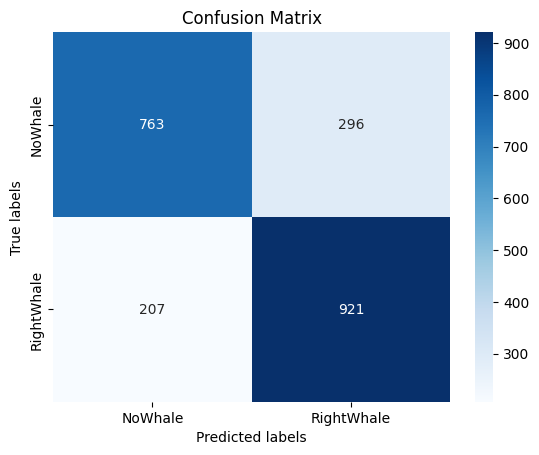

In [28]:
cm = confusion_matrix(y_test, predicted_labels)

categories = ['NoWhale', 'RightWhale']

# Graficar la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=categories,   
            yticklabels=categories)   
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [29]:
y_test = np.where(y_test == 'RightWhale', 1, 0)
predicted_labels = np.where(predicted_labels == 'RightWhale', 1, 0)

In [30]:
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)
roc_auc = roc_auc_score(y_test, predicted_labels)  

results = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
    'Value': [precision, recall, f1, roc_auc]
})

print(results)

      Metric     Value
0  Precision  0.756779
1     Recall  0.816489
2   F1 Score  0.785501
3    ROC-AUC  0.768490


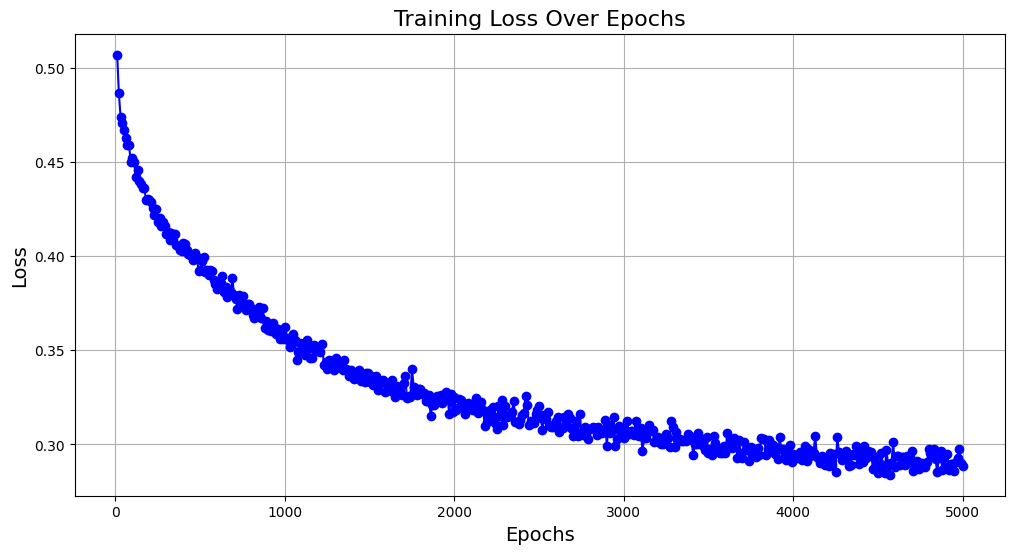

In [44]:
import re

def read_and_process_file(filename):
    with open(filename, 'r') as file:
        data_string = file.read()

    pattern = r"Epoch \[(\d+)/5000\], Loss: ([0-9.]+)"
    data = re.findall(pattern, data_string)

    df = pd.DataFrame(data, columns=['Epoch', 'Loss'])
    df['Epoch'] = df['Epoch'].astype(int)
    df['Loss'] = df['Loss'].astype(float)
    
    return df

filename = './experiments-results/mlp/accuracy-vs-epoch.txt'

df = read_and_process_file(filename)

plt.figure(figsize=(12, 6))
plt.plot(df['Epoch'], df['Loss'], marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs', fontsize=16) 
plt.xlabel('Epochs', fontsize=14)  
plt.ylabel('Loss', fontsize=14)  
plt.grid(True)
plt.show()